In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

import keras_tuner as kt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import layers
from matplotlib import pyplot as plt
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tqdm.auto import tqdm
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

sys.path += ['..']
from readers.base import NeuralynxReader, OpenEphysReader, buffer

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Train

In [46]:
# savemat('../output/annotation_set.mat', {'x_train': x_train, 'labels': labels})
m = loadmat('/media/sil2/Data/regev/stellagama/annotation_set.mat')
x_train, x_test, labels = m['x_train'], m['x_test'], m['labels']
labels = np.char.strip(labels)

In [49]:
x_train = x_train[:, :1732, :]
x_test = x_test[:, :1732, :]

In [52]:
def build_model(hp):
    kernel_size = hp.Int("kernel_size", min_value=7, max_value=57, step=5)
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.8, step=0.1)
    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(rate=dropout_rate),
            layers.Conv1D(filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Flatten(),
            layers.Conv1DTranspose(filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(rate=dropout_rate),
            layers.Conv1DTranspose(filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=1, kernel_size=kernel_size, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    print(model.summary())
    return model

def conv_ae(kernel_size, dropout_rate, latent_dim):
    encoder = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=dropout_rate),
            layers.BatchNormalization(),
            layers.Conv1D(filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=dropout_rate),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(latent_dim, name='latent_layer'),
        ]
    )
    volume_size = K.int_shape(encoder.layers[-3].output)
    decoder = keras.Sequential(
        [
            layers.Input(shape=(latent_dim,)),
            layers.Dense(np.prod(volume_size[1:])),
            layers.Reshape((volume_size[1], volume_size[2])),
            layers.Conv1DTranspose(filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=dropout_rate),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=dropout_rate),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=1, kernel_size=kernel_size, padding="same")
        ]
    )
    inputs = encoder.inputs
    autoencoder = keras.Model(inputs, decoder(encoder(inputs)), name="autoencoder")
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    return autoencoder, encoder, decoder

def tune_conv_ae(hp):
    kernel_size = hp.Int("kernel_size", min_value=7, max_value=57, step=5)
    dropout_rate = hp.Float("dropout_rate", min_value=0.05, max_value=0.8, step=0.05)
    latent_dim = hp.Int("latent_dim", min_value=2, max_value=30, step=1)
    autoencoder, _, _ = conv_ae(kernel_size, dropout_rate, latent_dim)
    return autoencoder

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=tune_conv_ae,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="ae",
    project_name="lfp-ae-latent",
)
tuner.search(x_train, x_train,
             epochs=30,
             validation_data=(x_test, x_test),
             callbacks=[
                 keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
             ])
tuner.results_summary()

In [ ]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]

In [ ]:
i = 8
x = x_test[i:i+1,:,:]
pred = best_model.predict(x)
plt.plot(x.flatten())
plt.plot(pred.flatten())

In [66]:
vars(best_model)

{'_self_setattr_tracking': True,
 '_is_model_for_instrumentation': True,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_input_spec': None,
 '_build_input_shape': TensorShape([None, 2400, 1]),
 '_saved_model_inputs_spec': TensorSpec(shape=(None, 2400, 1), dtype=tf.float32, name='input_1'),
 '_saved_model_arg_spec': ([TensorSpec(shape=(None, 2400, 1), dtype=tf.float32, name='input_1')],
  {}),
 '_supports_masking': True,
 '_name': 'autoencoder',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7efafc95da90>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f354e5b4240>,
 '_dtype_policy': <Policy "float32">,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_self_tracked_trackables': [<kera

In [20]:
x_train.shape

(1632, 1732, 1)

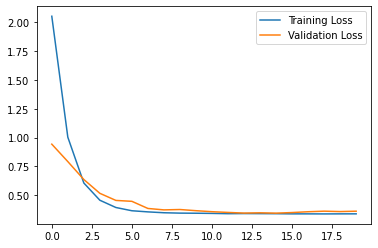

In [54]:
ae, encoder, _ = conv_ae(kernel_size=27, dropout_rate=0.5, latent_dim=3)
history = ae.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

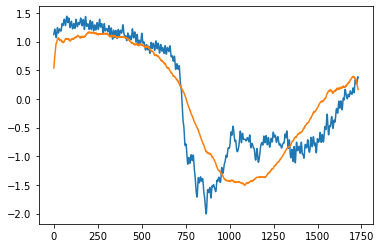

In [22]:
i = 8
x = x_test[i:i+1,:,:]
pred = ae.predict(x)
plt.plot(x.flatten())
plt.plot(pred.flatten())

In [55]:
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)
encoded = np.vstack([encoded_train, encoded_test])
encoded.shape

(1814, 3)

ShW: 81
ShW_broken: 22
small_ShW: 3
spindles: 365
saw: 1343


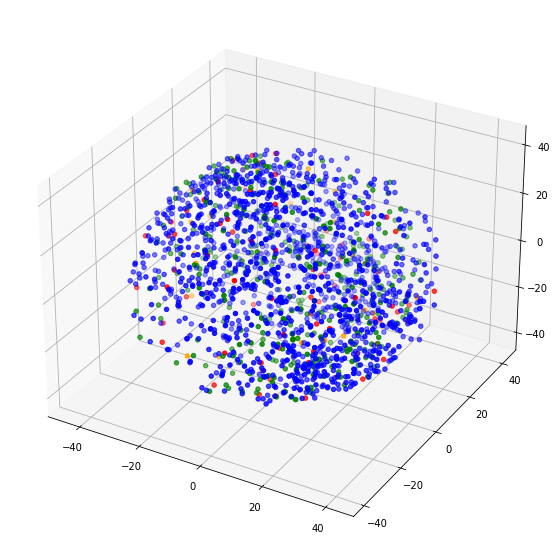

In [57]:
from mpl_toolkits.mplot3d import Axes3D

enc_embedded = encoded
# enc_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(encoded)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
colors = {
    'ShW': 'red',
    'ShW_broken': 'orange',
    'small_ShW': 'pink',
    'spindles': 'green',
    'saw': 'blue'
}
for g, color in colors.items():
    idx = np.where(labels==g)[0]
    print(f'{g}: {len(idx)}')
    ax.scatter(enc_embedded[idx,0], enc_embedded[idx,1], enc_embedded[idx,2], c=color, label=g)
# plt.legend()